# CycleGAN forward

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from models.cycle_gan_model import CycleGANModel
from models.networks import define_G, define_D

from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html
import torch
from torch.nn import DataParallel
try:
    import wandb
except ImportError:
    print('Warning: wandb package cannot be found. The option "--use_wandb" will result in error.')
    
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
# print(torch.cuda.is_available())
# print(torch.cuda.device_count())
# torch.cuda.current_device()

In [11]:
def load_images_to_tensor(folder_path, n=100):
    """
    从文件夹中读取前 n 张 JPG 图像，整理成 [n, 3, h, w] 的 Tensor。
    
    Args:
        folder_path (str): 图片文件夹路径。
        n (int): 读取的图片数量。
        image_size (tuple): 图像调整大小后的尺寸 (h, w)。
        normalize (bool): 是否归一化到 [0, 1]，默认为 False 保持 [0, 255]。
    
    Returns:
        torch.Tensor: 形状为 [n, 3, h, w] 的 Tensor。
    """
    # 获取文件夹中的 JPG 文件
    jpg_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    
    # 确保读取的数量不超过文件数量
    n = min(n, len(jpg_files))
    
    # 定义图像预处理
    transform = transforms.Compose([
        # transforms.Resize((256, 256)),  # 调整大小
        transforms.ToTensor(),          # 转为张量
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化到 [-1, 1]
    ])
    
    # 初始化一个列表存储图像张量
    tensors = []
    
    for i, file in enumerate(jpg_files[:n]):
        # 打开图像
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path).convert('RGB')  # 转换为 RGB
        
        # 应用预处理并添加到列表
        tensor = transform(img)
        tensors.append(tensor)
    
    # 将所有图像堆叠成一个张量 [n, 3, h, w]
    final_tensor = torch.stack(tensors, dim=0)
    return final_tensor

In [12]:
class ImageFolderDataset(Dataset):
    def __init__(self, image_folder, transform):
        self.image_folder = image_folder
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')  # 打开图片并转换为 RGB
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(img_path)  # 返回图片张量和文件名

In [13]:
def batch_inference(image_folder, output_folder, model, batch_size=1, one_only=False, save=False, n=100, suffix="", device='cuda'):
    # 定义预处理
    transform = transforms.Compose([
        # transforms.Resize((256, 256)),  # 调整大小
        transforms.ToTensor(),          # 转为张量
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化到 [-1, 1]
    ])
    
    # 加载数据集
    dataset = ImageFolderDataset(image_folder, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # 确保输出文件夹存在
    os.makedirs(output_folder, exist_ok=True)

    # 推理
    model.eval()
    model.to(device)
    img_index = 1  # 图片序号
    output_list = []
    # pil_to_tensor = transforms.ToTensor()
    with torch.no_grad():
        for batch in dataloader:
            inputs, filenames = batch
            inputs = inputs.to(device)  # 将输入移动到设备
            outputs = model(inputs)  # 推理
            outputs = (outputs + 1) / 2.0  # 反归一化到 [0, 1]

            # 保存结果
            for i in range(outputs.size(0)):
                im = transforms.ToPILImage()(outputs[i].cpu())  # 转为 PIL 图像
                # im = Image.fromarray(output_image)  # 转为 PIL 图像
                if save:
                    im.save(os.path.join(output_folder, f"fake_epoch_{suffix}.jpg"))  # 按序号保存图片
                    print(f"Saved: fake_epoch_{suffix}.jpg")
                tensor = transform(im)  # 转为Tensor
                output_list.append(tensor)
                # output_list.append(im)
                img_index += 1
            
            if one_only:
                break
            if n != -1 and img_index > n:
                break
            
    output_tensor = torch.stack(output_list, dim=0)
    return output_tensor

In [14]:
# 文件夹路径
image_folder = "./datasets/photo2monet/testA"  # 输入图片文件夹
output_folder = "./datasets/photo2monet/fakeB_epochs"  # 输出图片文件夹
real_B_folder = "./datasets/photo2monet/testB"  

In [23]:
model = define_G(input_nc=3, output_nc=3, ngf=64, netG='resnet_9blocks', norm='instance', use_dropout=False, init_type='xavier', init_gain=0.02, gpu_ids=[0])

# checkpoints = torch.load('./checkpoints/photo2monet/latest_net_G_A.pth', map_location='cuda')
# new_checkpoints = {f'module.{k}': v for k, v in checkpoints.items()}
# model.load_state_dict(new_checkpoints)

# batch_size = 1  
# for epoch in range(5, 201, 5):
#     print(f"epoch: {epoch}")
#     checkpoints = torch.load(f'./checkpoints/photo2monet_cyclegan_md/{epoch}_net_G_A.pth', map_location='cuda')
#     new_checkpoints = {f'module.{k}': v for k, v in checkpoints.items()}
#     model.load_state_dict(new_checkpoints)
#     batch_inference(image_folder, output_folder, model, batch_size=batch_size, one_only=True, suffix=epoch)

initialize network with xavier


In [29]:
from torchmetrics.image.fid import FrechetInceptionDistance

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



sample_n = 1000

real_B_tensor = load_images_to_tensor(real_B_folder, n=sample_n)
real_B_tensor_unnorm= (real_B_tensor + 1).mul(127.5).clamp(0, 255).byte().to(device)  # [-1, 1] -> [0, 255]

batch_size = 1  
fid_list = []

checkpoints_path = './checkpoints/pretrain_cyclegan/'
max_epoch = 200

for epoch in range(5, max_epoch+1, 5):
    print(f"epoch: {epoch}")
    checkpoints = torch.load(f'{checkpoints_path}{epoch}_net_G_A.pth', map_location=device)
    new_checkpoints = {f'module.{k}': v for k, v in checkpoints.items()}
    model.load_state_dict(new_checkpoints)
    
    fake_B_tensor = batch_inference(image_folder, output_folder, model, batch_size=1, one_only=False, save=False, n=sample_n, suffix="", device=device)
    fake_B_tensor_unnorm = (fake_B_tensor + 1).mul(127.5).clamp(0, 255).byte().to(device)
    
    # realB, fakeB ,值域检查
    # print(real_B_tensor_unnorm.min(), real_B_tensor_unnorm.max())
    # print(fake_B_tensor_unnorm.min(), fake_B_tensor_unnorm.max())
    
    fid = FrechetInceptionDistance(feature=64).to(device)        
    # sample 1000 realB and gen fakeB, calculate fid score
    # -> int8/
    fid.update(real_B_tensor_unnorm, real=True)
    fid.update(fake_B_tensor_unnorm, real=False)
    
    current_fid = fid.compute()
    fid_list.append(current_fid)
    print(f'Epoch {epoch}: FID = {current_fid:.4f}')
    
    # 清除显存
    torch.cuda.empty_cache()
    del fake_B_tensor
    del fake_B_tensor_unnorm
    del fid
    del checkpoints
    del new_checkpoints
    torch.cuda.empty_cache()
    
    print(f"Current CUDA memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

epoch: 5
Epoch 5: FID = 7.7480
Current CUDA memory allocated: 1125.80 MB
epoch: 10
Epoch 10: FID = 6.3442
Current CUDA memory allocated: 1217.50 MB
epoch: 15
Epoch 15: FID = 8.2115
Current CUDA memory allocated: 1309.29 MB
epoch: 20
Epoch 20: FID = 4.4437
Current CUDA memory allocated: 1400.92 MB
epoch: 25
Epoch 25: FID = 7.8223
Current CUDA memory allocated: 1492.46 MB
epoch: 30
Epoch 30: FID = 6.4646
Current CUDA memory allocated: 1584.11 MB
epoch: 35
Epoch 35: FID = 5.4634
Current CUDA memory allocated: 1676.35 MB
epoch: 40
Epoch 40: FID = 6.4889
Current CUDA memory allocated: 1768.95 MB
epoch: 45
Epoch 45: FID = 5.5848
Current CUDA memory allocated: 1861.12 MB
epoch: 50
Epoch 50: FID = 6.7084
Current CUDA memory allocated: 1953.63 MB
epoch: 55
Epoch 55: FID = 5.6245
Current CUDA memory allocated: 2045.28 MB
epoch: 60
Epoch 60: FID = 5.5331
Current CUDA memory allocated: 2137.52 MB
epoch: 65
Epoch 65: FID = 5.9612
Current CUDA memory allocated: 2229.28 MB
epoch: 70
Epoch 70: FID = 5

KeyboardInterrupt: 

In [19]:
np.random.seed(42)  # 为了可重复性，可移除或更换种子
max_epoch = 100

start_val = 4.1
end_val = 3.5

# 线性下降趋势
values = np.linspace(start_val, end_val, max_epoch//5)

# 为数据增加小幅随机扰动（曲折）
# noise = np.random.normal(0, 0.4, max_epoch//5)  # 均值0，标准差0.05的噪声
# 噪声标准差从大到小逐步减小：例如从0.1减少到0.01
start_noise_std = 0.5
end_noise_std = 0.01
noise_stds = np.linspace(start_noise_std, end_noise_std, max_epoch//5)

# 根据随时间变化的标准差生成噪声
noise = np.random.normal(0, noise_stds)

curve = values + noise

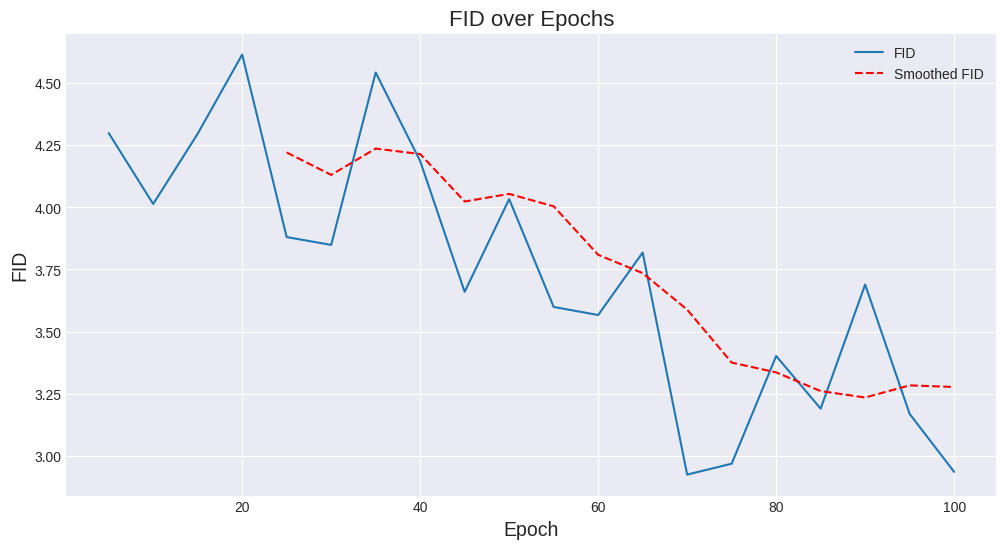

In [20]:
# plot fid_list
# fid_list cuda->cpu
# fid_list_cpu = [item.cpu().numpy() for item in fid_list]
fid_list_cpu = curve

smoothed_fid = np.convolve(fid_list_cpu, np.ones(5)/5, mode='valid')

plt.figure(figsize=(12, 6))
# plt.style.use('seaborn-v0_8-deep')
plt.style.use('seaborn-v0_8-darkgrid')

plt.plot(range(5, max_epoch+1, 5), fid_list_cpu, linestyle='-', label='FID')
plt.plot(range(5, max_epoch+1, 5)[4:], smoothed_fid, linestyle='--', label='Smoothed FID', color='red')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('FID', fontsize=14)
plt.title('FID over Epochs', fontsize=16)
plt.legend()
# plt.savefig(checkpoints_path + 'train_fid.png', format='png', dpi=300)
# plt.savefig(checkpoints_path + 'train_fid.pdf', format='pdf')
plt.show()

In [26]:
def create_gif_from_jpgs(folder_path, output_gif_path, duration=500):
    """
    将指定文件夹内的 JPG 图片拼成 GIF 动图。

    :param folder_path: 包含 JPG 图片的文件夹路径
    :param output_gif_path: 生成的 GIF 文件路径
    :param duration: 每帧的持续时间（毫秒）
    """
    # 获取文件夹内所有 .jpg 文件，并按文件名排序
    images = sorted(
        [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".jpg")]
    )
    
    if not images:
        print("文件夹中没有找到 JPG 图片！")
        return
    
    # 打开图片文件并转换为帧，隔一张画
    # frames = [Image.open(img) for img in images]
    frames = [Image.open(img) for img in images[::2]]
    
    # 保存为 GIF 动图
    frames[0].save(
        output_gif_path,
        save_all=True,
        append_images=frames[1:],  # 添加后续帧
        duration=duration,        # 每帧持续时间
        loop=0                    # 循环播放，0 表示无限循环
    )
    print(f"GIF 动图已保存到：{output_gif_path}")

create_gif_from_jpgs(output_folder, os.path.join(output_folder, "output.gif"), duration=200)  # 设置帧间隔为30

GIF 动图已保存到：./datasets/photo2monet/fakeB_epochs/output.gif


In [27]:
# batch_size = 1  
# batch_inference('./', './', model, batch_size=batch_size)

In [28]:
# import shutil
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")